# Utils

Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Paths
path_labels = '/kaggle/input/fcmaps-metadata/labels.csv'
path_fcmaps = '/kaggle/input/fcmaps-processed'                   
path_fcmaps_augmented = '/kaggle/input/fcmaps-augmented-processed/FCmaps_augmented_processed'

# Load labels
df_labels = pd.read_csv(path_labels)

# Temporary:
to_exclude = ['3_S_5003', '4_S_5003', '4_S_5005', '4_S_5007', '4_S_5008']
df_labels = df_labels[~df_labels['ID'].isin(to_exclude)].reset_index(drop=True)

In [ ]:
# Parameters
batch_size = 4
epochs = 10
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task = 'classification'               # or 'regression'
n_folds = 10

if task == 'classification':
    criterion = nn.CrossEntropyLoss()
    n_classes = 2  
    label_column = 'Group'
else:
    criterion = nn.MSELoss()
    n_classes = 1
    #label_column = 'Age'

# Dataset

In [ ]:
class FCDataset(Dataset):
    def __init__(self, data_dir, df_labels, label_column, task, transform=None):       
        self.data_dir = data_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.label_column = label_column
        self.task = task
        self.transform = transform
    
        # Dictionary for mapping strings to indices if labels are not numbers
        if not pd.api.types.is_numeric_dtype(self.df_labels[self.label_column]):
            unique_labels = sorted(self.df_labels[self.label_column].unique())
            self.label_mapping = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label_mapping = None
            
        self.samples = []

        # Loop over each row of the dataframe
        for _, row in self.df_labels.iterrows():
            subj_id = row['ID']
            
            if self.task == 'classification':
                # Classification: map the labels
                label = self.label_mapping[row[self.label_column]]
            
            else:  
                # Regression: convert to float
                label = float(row[self.label_column])

            # Reconstruct the file paths 
            file_path = os.path.join(data_dir, f"{subj_id}.processed.npy")
            if os.path.exists(file_path):
                self.samples.append((file_path, label))
            else:
                print(f"Missing file: {file_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        
        # Load and reshape the volume: (1, 91, 109, 91)
        volume = np.load(file_path)
        volume = np.expand_dims(volume, axis=0)  

        # Covert volume into a tensor
        x = torch.tensor(volume, dtype=torch.float32)

        # Convert the label into a tensor
        if self.task == 'classification':
            y = torch.tensor(label, dtype=torch.long)
        else: 
            y = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            x = self.transform(x)

        return x, y

In [ ]:
class AugmentedFCDataset(Dataset):
    def __init__(self, data_dir, df_labels, label_column, task, transform=None):
        
        self.data_dir = data_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.label_column = label_column
        self.task = task
        self.transform = transform

        # Mapping
        if not pd.api.types.is_numeric_dtype(self.df_labels[self.label_column]):
            unique_labels = sorted(self.df_labels[self.label_column].unique())
            self.label_mapping = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label_mapping = None
            
        self.samples = []

        for _, row in self.df_labels.iterrows():
            subj_id = row['ID']

            if self.task == 'classification':
                label = self.label_mapping[row[self.label_column]]
            else:
                label = float(row[self.label_column])

            # Loop over each subject folder and list each augmentation
            subject_folder = os.path.join(data_dir, subj_id)
            if os.path.isdir(subject_folder):
                for file in os.listdir(subject_folder):
                    if file.endswith('.npy'):
                        file_path = os.path.join(subject_folder, file)
                        self.samples.append((file_path, label))
            else:
                print(f"Warning: missing augmented folder for subject {subj_id}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load and reshape the volume: (1, 91, 109, 91)
        volume = np.load(file_path)
        volume = np.expand_dims(volume, axis=0)

        x = torch.tensor(volume, dtype=torch.float32)

        if self.task == 'classification':
            y = torch.tensor(label, dtype=torch.long)
        else:
            y = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            x = self.transform(x)

        return x, y

# CNN Models

## Network

In [ ]:
class SimpleCNN3D(nn.Module):
    def __init__(self, n_classes):
        super(SimpleCNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.AdaptiveAvgPool3d(1)

        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


class ResNet3D(nn.Module):
    def __init__(self, n_classes):
        super(ResNet3D, self).__init__()
        self.model = r3d_18(weights=None)
        self.model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3), bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

## Training, Validation and Testing loops

Training function

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    # Enable training mode
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_batch)

        # Compute loss
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    return train_loss

Validation function

In [ ]:
def validate(val_loader, model, criterion, device, task):
    # Set model to evaluation mode
    model.eval()
    running_loss = 0.0
    correct = 0

    # Disable gradient computation
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            running_loss += loss.item() * x_val.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)
    return val_loss, val_accuracy

Evaluation function (to get predictions)

In [ ]:
def evaluate(model, loader, task, device):
    model.eval()
    true_labels, pred_labels = [], []

    # Disable gradient computation
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            # Convert output to prediction
            if task == 'classification':
                preds = torch.argmax(outputs, dim=1)  
            else:
                preds = outputs.squeeze()  

            # Store true and predicted values
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(pred_labels)

# Data

Load some files for example

In [ ]:
img3D = np.load('/kaggle/input/fcmaps-processed/002_S_4654.processed.npy')

print(img3D.shape)
print(img3D.dtype)

## Pairwise classification

- ADNI + CBS = 116 
- CBS + PSP = 105 
- ADNI + PSP = 133

In [ ]:
group1 = 'ADNI'
group2 = 'PSP'

df_pair = df_labels[df_labels['Group'].isin([group1, group2])].reset_index(drop=True)

In [ ]:
df_pair.shape

## Splitting

In [ ]:
train_df, test_df = train_test_split(
    df_pair,
    test_size=0.2,
    stratify=df_pair['Group'],
    random_state=42
)

Check the balance between groups

In [ ]:
print(train_df['Group'].value_counts())
print(test_df['Group'].value_counts())

Example of augmentation

In [ ]:
train_dataset = AugmentedFCDataset(path_fcmaps_augmented, train_df, label_column, task)

In [ ]:
print("Shape before augmentation: ", train_df.shape )
print("Shape after augmentation: ", len(train_dataset) )

# Training

In [ ]:
# For k-fold cross-validation
skf = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state=42)

# Subjects and correspondent labels 
subjects = train_df['ID'].values
labels = train_df[label_column].values
all_train_losses = []
all_val_losses = []

# Loop over the k-fold
for fold, (train_idx, val_idx) in enumerate(skf.split(subjects, labels)):
    print(f"\n--- Fold {fold+1} ---")
    
    # Subjects for the current fold
    df_train_fold = train_df[train_df['ID'].isin(subjects[train_idx])]
    df_val_fold   = train_df[train_df['ID'].isin(subjects[val_idx])]

    # Create Datasets
    train_dataset = AugmentedFCDataset(path_fcmaps_augmented, df_train_fold, label_column, task)
    val_dataset = FCDataset(path_fcmaps, df_val_fold, label_column, task)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create the model and optimizer 
    model = SimpleCNN3D(n_classes=2).to(device)
    #model = ResNet3D(n_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Variables
    best_loss = float('inf')
    best_accuracy = -float('inf')
    best_epoch = -1
    best_model_path = None
    train_losses, val_losses = [], []
    
   # Loop over epochs
    for epoch in range(epochs):        
        train_loss = train(train_loader, model, criterion, optimizer, device)
        val_loss, val_accuracy = validate(val_loader, model, criterion, device, task)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

        # Append losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save best model based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_epoch = epoch + 1
            best_model_path = f"best_fold{fold}_epoch{best_epoch}.pt"
            torch.save(model.state_dict(), best_model_path)

    # Save for plotting
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

In [ ]:
def plot_all_folds(all_train_losses, all_val_losses):
    cols = 2
    rows = (n_folds + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = axes.flatten()

    for i in range(n_folds):
        ax = axes[i]
        ax.plot(all_train_losses[i], label='Train Loss')
        ax.plot(all_val_losses[i], label='Validation Loss')
        ax.set_title(f'Fold {i+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.grid(True)
        ax.legend()

    # Rimuovi eventuali subplot vuoti se n_folds è dispari
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Training and Validation Loss per Fold', fontsize=16, y=1.02)
    plt.show()

# Plot
plot_all_folds(all_train_losses, all_val_losses)


# Evaluation

In [ ]:
print(f"\nBest validation accuracy: {best_accuracy:.4f} at epoch {best_epoch}")
print(f"Best model saved at: {best_model_path}")

In [ ]:
# Dataset and DataLoaders
test_dataset = FCDataset(path_fcmaps, test_df, label_column, task)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = SimpleCNN3D(n_classes=n_classes).to(device)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()

# Test
y_true, y_pred = evaluate(model, test_loader, task, device)

## Classification

In [ ]:
# Metrics
report = classification_report(
    y_true, y_pred,
    output_dict=True,
    zero_division=0  
)

df_report = pd.DataFrame(report).transpose()

In [ ]:
df_report.round(3)

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### TODO:
- Multiclass Precision-Recall Curve
- Plotting the Multiclass ROC Curve

# Synthetic data

Synthetic data creation

In [22]:
n_samples = 1500  # total samples (750 per class)
img_shape = (1, 91, 109, 91)  # volume shape
block_coords = (slice(30, 50), slice(40, 60), slice(30, 50))  # distinguishable block

# Create random noise data
synthetic_data = np.random.normal(0, 1, (n_samples, *img_shape))
synthetic_labels = np.array([0]*750 + [1]*750)

# Inject a distinguishable pattern for class 1
for i in range(750, 1500):
    synthetic_data[i, 0, block_coords[0], block_coords[1], block_coords[2]] += 5

print(f"Data shape: {synthetic_data.shape}, Labels shape: {synthetic_labels.shape}")

Data shape: (1500, 1, 91, 109, 91), Labels shape: (1500,)


Class Dataset

In [23]:
class SyntheticDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

Train / Validation Split and Dataloaders

In [24]:
# Splitting
# First split: Train (80%) + Temp (20%)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    synthetic_data, synthetic_labels, test_size=0.2, stratify=synthetic_labels, random_state=42
)

# Second split: Validation (10%) + Test (10%)
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Check sizes
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

# Datasets
train_dataset = SyntheticDataset(train_data, train_labels)
val_dataset = SyntheticDataset(val_data, val_labels)
test_dataset = SyntheticDataset(test_data, test_labels)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Train samples: 1200
Validation samples: 150
Test samples: 150


## Simple CNN

Model and training

In [25]:
# Create model, criterion, optimizer
model = SimpleCNN3D(n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training variables
n_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(n_epochs):
    train_loss = train(train_loader, model, criterion, optimizer, device)
    val_loss, val_acc = validate(val_loader, model, criterion, device, task='classification')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

Epoch 1/20 | Train Loss: 0.4127 | Val Loss: 0.2336 | Val Accuracy: 1.0000
Epoch 2/20 | Train Loss: 0.2336 | Val Loss: 1.7777 | Val Accuracy: 0.5000
Epoch 3/20 | Train Loss: 0.1207 | Val Loss: 0.0707 | Val Accuracy: 1.0000
Epoch 4/20 | Train Loss: 0.0644 | Val Loss: 0.4919 | Val Accuracy: 0.5000
Epoch 5/20 | Train Loss: 0.0415 | Val Loss: 0.1179 | Val Accuracy: 1.0000
Epoch 6/20 | Train Loss: 0.0280 | Val Loss: 0.0212 | Val Accuracy: 1.0000
Epoch 7/20 | Train Loss: 0.0209 | Val Loss: 0.0165 | Val Accuracy: 1.0000
Epoch 8/20 | Train Loss: 0.0144 | Val Loss: 0.0059 | Val Accuracy: 1.0000
Epoch 9/20 | Train Loss: 0.0134 | Val Loss: 0.0037 | Val Accuracy: 1.0000
Epoch 10/20 | Train Loss: 0.0103 | Val Loss: 0.0151 | Val Accuracy: 1.0000
Epoch 11/20 | Train Loss: 0.0074 | Val Loss: 0.0061 | Val Accuracy: 1.0000
Epoch 12/20 | Train Loss: 0.0064 | Val Loss: 0.0013 | Val Accuracy: 1.0000
Epoch 13/20 | Train Loss: 0.0045 | Val Loss: 0.0046 | Val Accuracy: 1.0000
Epoch 14/20 | Train Loss: 0.0050 |

Plotting

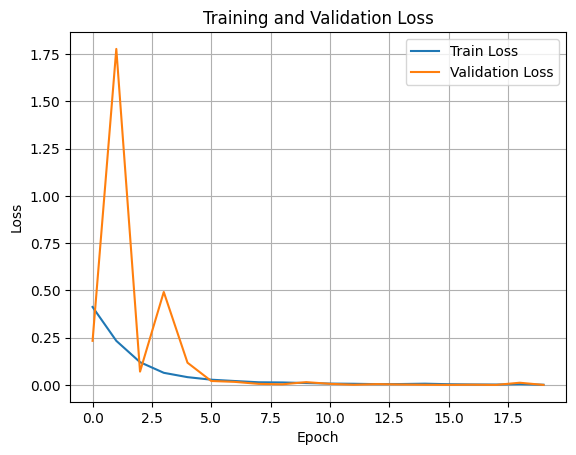

In [26]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

Prediction

In [30]:
# Prediction
y_true, y_pred = evaluate(model, test_loader, task='classification', device=device)

Test Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150
 



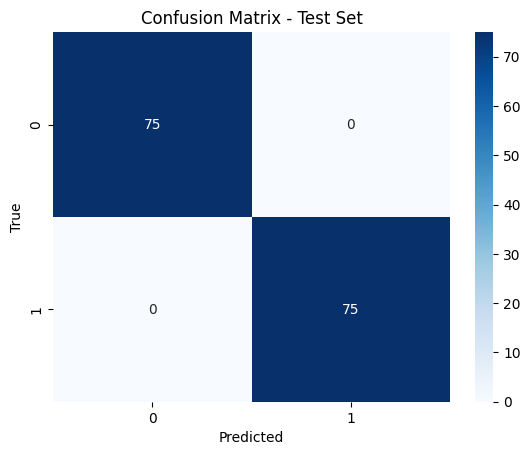

In [31]:
# Performance
print("Test Classification Report:\n")
print(classification_report(y_true, y_pred), '\n')

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## ResNet

In [33]:
# Create model, criterion, optimizer
model = ResNet3D(n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training variables
n_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(n_epochs):
    train_loss = train(train_loader, model, criterion, optimizer, device)
    val_loss, val_acc = validate(val_loader, model, criterion, device, task='classification')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 0.0616 | Val Loss: 0.0001 | Val Accuracy: 1.0000
Epoch 2/10 | Train Loss: 0.0013 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 3/10 | Train Loss: 0.0005 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 4/10 | Train Loss: 0.0002 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 5/10 | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 6/10 | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 7/10 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 8/10 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 9/10 | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 10/10 | Train Loss: 0.0000 | Val Loss: 0.0001 | Val Accuracy: 1.0000


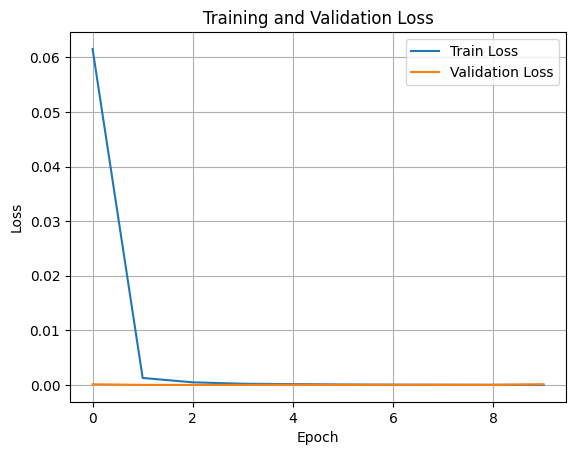

In [34]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [36]:
# Prediction
y_true, y_pred = evaluate(model, test_loader, task='classification', device=device)

Test Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150
 



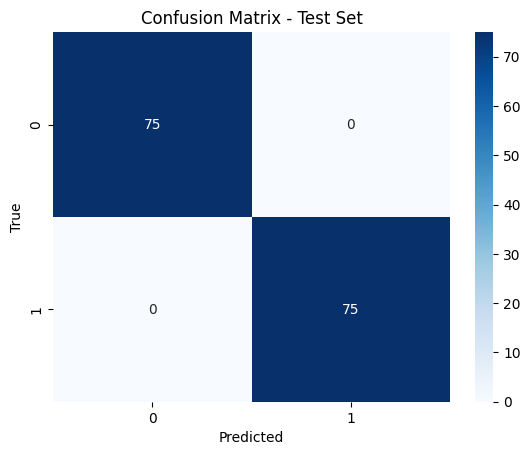

In [37]:
# Performance
print("Test Classification Report:\n")
print(classification_report(y_true, y_pred), '\n')

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()